In [31]:
import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
#import plotly.offline as py
from IPython.display import Image
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR



import csv
import scipy.stats as ss
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import os

## Read data & data cleaning

In [32]:
df = pd.read_csv('Austin.csv').fillna(0)

df['Date'] = df['Date'].apply(lambda d: datetime.datetime.strptime(d[:-3], '%Y/%m/%d %H:%M:%S'))
#pd.to_datetime(df.Date)
df = df.sort_values('Date')
df.head()

,Date,Notes,Zip_76574,Zip_78605,Zip_78610,Zip_78612,Zip_78613,Zip_78615,Zip_78616,Zip_78617,...,Zip_78750,Zip_78751,Zip_78752,Zip_78753,Zip_78754,Zip_78756,Zip_78757,Zip_78758,Zip_78759,FID
0,2020-03-26 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,3.0,2.0,3.0,1.0,2.0,5.0,4.0,5.0,74
1,2020-03-27 17:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,4.0,2.0,3.0,2.0,2.0,8.0,4.0,5.0,114
2,2020-03-28 17:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3.0,4.0,2.0,3.0,2.0,2.0,8.0,5.0,6.0,115
3,2020-03-29 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,5.0,3.0,4.0,2.0,2.0,8.0,5.0,6.0,116
4,2020-03-30 17:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,3.0,5.0,3.0,4.0,1.0,2.0,7.0,5.0,6.0,117


In [33]:
## fill in na values

col = df.columns
zip_col = []
for c in col:
    if c[:3] == 'Zip':
        zip_col.append(c)
#print(zip_col)

for i,row in df.iterrows():
    #print(row['Zip_76574'])
    if all([row[c] == 0 for c in zip_col]):
        for c in zip_col:
            df.at[i, c] = df.at[i-1, c]
        #print(row)

## ARIMA model tuning

In [34]:
# check stationarity

def stationarity(sample):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(sample, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

## ARIMA

def train_model(train, p, d, q):
    arima = ARIMA(train, order =(p, d, q)) # p, d, q
    # p = periods for autoregressive model
    # d = integrated order, diff
    # q = periods in moving average
    arima = arima.fit(trend='c', full_output=True, disp=True)
    #print('AIC score', p, d, q, arima.aic)
    return arima

def train_ar_model(train):
    ar = AR(train)
    ar = ar.fit(max_lag=2, trend='c', full_output=True, disp=True)
    #print(ar.AIC)
    return ar


def forcast_test(arima, train, test):
    num_steps = len(test)

    forecast = arima.forecast(steps = num_steps)
    pred = list(forecast[0])

    start_date = df['Date'][len(train) - 1]
    #start_date = datetime.datetime.strptime(start_date[:-3], '%Y/%m/%d %H:%M:%S')

    prediction_dates = []
    for i in range(num_steps):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date
        
    return prediction_dates, pred

def forcast_test_ar(ar, train, test):
    num_steps = len(test)

    forecast = ar.forecast(steps = num_steps)
    pred = list(forecast[0])

    start_date = df['Date'][len(train) - 1]
    #start_date = datetime.datetime.strptime(start_date[:-3], '%Y/%m/%d %H:%M:%S')

    prediction_dates = []
    for i in range(num_steps):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date
        
    return prediction_dates, pred


def forcast(arima, num_steps):

    forecast = arima.forecast(steps = num_steps)
    pred = list(forecast[0])

    start_date = df['Date'][len(df) - 1]
    print(start_date)
    #start_date = datetime.datetime.strptime(start_date[:-3], '%Y/%m/%d %H:%M:%S')

    prediction_dates = []
    for i in range(num_steps):
        date = start_date + datetime.timedelta(days=1)
        prediction_dates.append(date)
        start_date = date
        
    return prediction_dates, pred

In [35]:
sample = df['Zip_78617']
print(len(sample))

train = sample[:170]
test = sample[170:]

219


2020-11-04 17:00:00


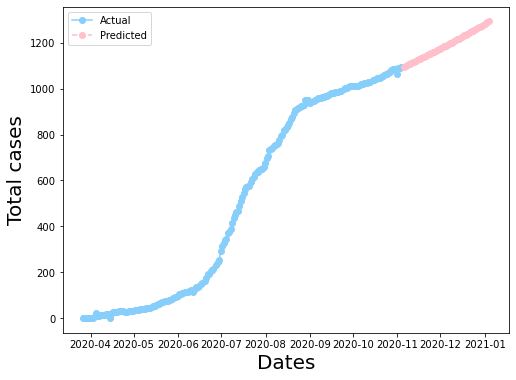

In [36]:
p, d, q = 5,2,0

train = sample

arima = train_model(sample, p, d, q)
#prediction_dates, pred = forcast_test(arima, train, test)
prediction_dates, pred = forcast(arima,60)

plt.figure(figsize= (8,6))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
#plt.title("Predicted Values for the next 30 Days" , fontsize = 20)

plt.plot_date(y=sample.tolist(),x=df['Date'],linestyle = '-',color = 'lightskyblue',label = 'Actual');
plt.plot_date(y = pred, x = prediction_dates,linestyle ='dashed',color = 'pink',label = 'Predicted');
#plt.plot_date(y = test, x = prediction_dates,linestyle ='dashed',color = 'blue',label = 'Actual');

plt.legend();

## Batch prediction

In [37]:
## batch predict

p, d, q = 5, 2, 0

output = {}

for i, zip_code in enumerate(zip_col):
    sample = df[zip_code]
    
    arima = train_model(sample, p, d, q)
    prediction_dates, predicted_cases = forcast(arima,60)
    
    if i == 0:
        output['Date'] = prediction_dates
    predicted_cases = [max(int(case),0) for case in predicted_cases]
    output[zip_code[4:]] = predicted_cases
    
output = pd.DataFrame(output)
output.head()

2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00
2020-11-04 17:00:00


,Date,76574,78605,78610,78612,78613,78615,78616,78617,78620,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
0,2020-11-05 17:00:00,0,0,75,24,89,13,5,1096,9,...,465,341,226,717,2088,853,117,415,1763,560
1,2020-11-06 17:00:00,0,0,75,24,89,13,5,1099,9,...,464,343,228,726,2115,849,118,414,1742,565
2,2020-11-07 17:00:00,0,0,75,24,90,13,5,1104,9,...,468,347,232,746,2177,881,120,427,1835,573
3,2020-11-08 17:00:00,0,0,75,24,90,13,5,1106,9,...,469,349,232,744,2159,874,121,428,1809,575
4,2020-11-09 17:00:00,0,0,75,24,91,13,5,1109,9,...,470,352,233,750,2173,879,121,433,1819,579


In [38]:
dates = output['Date']

output.index = output['Date']
output = output.drop(columns=['Date'])
output = output.transpose()
output.index.name = 'Zipcode'
output.head()

Date,2020-11-05 17:00:00,2020-11-06 17:00:00,2020-11-07 17:00:00,2020-11-08 17:00:00,2020-11-09 17:00:00,2020-11-10 17:00:00,2020-11-11 17:00:00,2020-11-12 17:00:00,2020-11-13 17:00:00,2020-11-14 17:00:00,...,2020-12-25 17:00:00,2020-12-26 17:00:00,2020-12-27 17:00:00,2020-12-28 17:00:00,2020-12-29 17:00:00,2020-12-30 17:00:00,2020-12-31 17:00:00,2021-01-01 17:00:00,2021-01-02 17:00:00,2021-01-03 17:00:00
Zipcode,,,,,,,,,,,,,,,,,,,,,
76574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78610,75,75,75,75,75,76,76,76,76,76,...,85,85,85,85,85,86,86,86,86,86
78612,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
78613,89,89,90,90,91,91,92,92,92,93,...,109,109,110,110,111,111,111,112,112,113


In [39]:
output.to_csv('prediction.csv')

## Classification model

In [40]:
#k-means

df1 = pd.read_csv('prediction.csv')
df2 = pd.read_csv('crime.csv')
df3 = pd.read_csv('housing_unit.csv')
df4 = pd.read_csv('population.csv')
df_merge1 = pd.merge(left=df2, right = df3, left_on = 'Zipcode', right_on = 'Zipcode')
df_merge2 = pd.merge(left=df_merge1, right = df4, left_on = 'Zipcode', right_on = 'Zipcode')
df_merge2 =df_merge2.replace(',','', regex = True)
df_merge2['pop_density']=df_merge2['pop_density'].astype(float)
df_merge2['Housingunits']=df_merge2['Housingunits'].astype(float)

In [41]:
df = pd.merge(left=df_merge2, right = df1, left_on = 'Zipcode', right_on = 'Zipcode')

In [42]:
dc = df.iloc[:, [0,1,2,3,4]]

In [43]:
df.iloc[:,0]
zipcode = pd.Series(df.iloc[:,0]).array
print (zipcode)

<PandasArray>
[78701, 78702, 78703, 78704, 78705, 78717, 78719, 78721, 78722, 78723, 78724,
 78725, 78726, 78727, 78728, 78729, 78730, 78731, 78732, 78733, 78734, 78735,
 78736, 78737, 78738, 78739, 78741, 78742, 78744, 78745, 78746, 78747, 78748,
 78749, 78750, 78751, 78752, 78753, 78754, 78756, 78757, 78758, 78759]
Length: 43, dtype: int64


In [44]:
df_label = []
df_label1 = []
#for i in range (0,3):
    
for i in range (0,df1.shape[1]-1):
    
    X = df.iloc[:, [1,2,3,(i+4)]]
    cols = X.columns 
    
    ms = MinMaxScaler()
    X = ms.fit_transform(X)
    X = pd.DataFrame(X, columns=[cols])
 
    kmeans = KMeans(n_clusters=4, random_state=0) 
    kmeans.fit(X)
    labels = kmeans.labels_
    
    df_label.append(labels)
    
    a0 = np.where(labels == 0)
    a1 = np.where(labels == 1)
    a2 = np.where(labels == 2)
    a3 = np.where(labels == 3)
    b = []
    b.append(np.average(X.iloc[a0[0],0]+X.iloc[a0[0],1]+X.iloc[a0[0],2]+X.iloc[a0[0],3]))
    b.append(np.average(X.iloc[a1[0],0]+X.iloc[a1[0],1]+X.iloc[a1[0],2]+X.iloc[a1[0],3]))
    b.append(np.average(X.iloc[a2[0],0]+X.iloc[a2[0],1]+X.iloc[a2[0],2]+X.iloc[a2[0],3]))
    b.append(np.average(X.iloc[a3[0],0]+X.iloc[a3[0],1]+X.iloc[a3[0],2]+X.iloc[a3[0],3]))
   
    c = ss.rankdata(b)

    
    labels1 = np.where(labels == 0, c[0]-1, labels)
    labels1 = np.where(labels == 1, c[1]-1, labels)
    labels1 = np.where(labels == 2, c[2]-1, labels)
    labels1 = np.where(labels == 3, c[3]-1, labels)
    
    df_label1.append(labels1)
  
    
    #ranks = numpy.empty_like(temp)
    #ranks[temp] = numpy.arange(len(array))
    #df_label = df_label.extend(labels, ignore_index = True)
    

In [45]:
file = open('classification.csv', 'w+', newline ='') 
  
# writing the data into the file 
with file:
    write_header = csv.DictWriter(file, fieldnames = zipcode)
    write_header.writeheader()
    write = csv.writer(file) 
    write.writerows(df_label1) 

In [46]:
df = pd.read_csv('classification.csv')
df.index = dates
df = df.transpose()
df.to_csv('classification.csv')